demo for class


### import (colab ver)

In [ ]:
# import os
# import torch
# import itertools
# os.environ['TORCH'] = torch.__version__
# os.environ['PYTHONWARNINGS'] = "ignore"
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch-geometric
# !pip3 install kmeans1d
# from torch_geometric.data import Data
# import torch.nn.functional as F
# from torch.nn import Linear
# import torch_geometric.transforms as T
# import sys
# import random
# import numpy as np
# import time
# import math
# import csv
# import datetime
# import math
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import pandas as pd
# import glob
# import random
# import torch.nn as nn
# import torch.optim as optim
# from collections import defaultdict
# from tqdm.notebook import tqdm
# from math import exp
# from chardet import detect
# from torch_geometric.nn.conv import MessagePassing
# from torch_geometric.utils import degree
# from sklearn import preprocessing as pp
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import scipy.sparse as sp
# from networkx.algorithms import bipartite
# import kmeans1d
# import copy
# from google.colab import drive

### import (local)

In [17]:
# --- 표준 라이브러리 ---
import os, sys, math, time, random, copy, glob, csv, datetime, itertools
from collections import defaultdict

# --- 과학 연산 / 시각화 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.sparse as sp

# --- PyTorch & PyG ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

# --- 기타 ---
from tqdm import tqdm
from chardet import detect
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import bipartite
import kmeans1d

# --- Device 선택 (Apple Silicon M4) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# MPS 미지원 연산 자동 CPU fallback 허용
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

print("Using device:", device)

Using device: mps


In [18]:
# hyperparameters
latent_dim = 128   # length of user/item embedding
num_layer = 3   # num.hop neighbor
rating_threshold = 7
batch_size = 500
epochs = 1000
learning_rate = 0.001
decay = 0.0001
topK = 3 # num. top recommend
dropout = 0.2
sample_rate = 0.2  # test size, train whole set

df = pd.read_csv('joke.csv')   #('movielens.csv')
print("*"*50)
print("Original dataset info.")
user_ids = sorted(df['userId'].unique())
item_ids = sorted(df['jokeId'].unique())
print("  Number of users = ", len(user_ids))
print("  Number of jokes = ", len(item_ids))
print("  Number of ratings = ", len(df))
print("*"*50)
print("After rating filtering")
print("  Rating threshhold = ", rating_threshold)
# df = df[df['rating']>=rating_threshold]  # consider only rating >= threshold
user_ids = sorted(df['userId'].unique())
item_ids = sorted(df['jokeId'].unique())
print("  Number of users = ", len(user_ids))
print("  Number of jokes = ", len(item_ids))
print("  Number of ratings = ", len(df))

**************************************************
Original dataset info.
  Number of users =  907
  Number of jokes =  145
  Number of ratings =  38319
**************************************************
After rating filtering
  Rating threshhold =  7
  Number of users =  907
  Number of jokes =  145
  Number of ratings =  38319


<positron-console-cell-30>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-30>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


LightGCN link prediction


100%|██████████| 1000/1000 [22:01<00:00,  1.32s/it]

           4          5         6    ...       148       149       150
1    -0.156202   6.809353 -0.312522  ... -2.804477 -0.921935 -0.560956
2    -0.143989  10.529657 -0.164989  ...  0.065621 -0.493578 -0.873474
3    -0.608663  11.124718 -0.618082  ...  2.673353  0.212959 -0.385369
4     0.016459   9.672405 -0.014384  ... -0.726788 -0.620222 -0.801685
5    -0.133961  10.286700 -0.203340  ... -0.625308 -0.076892 -1.311064
...        ...        ...       ...  ...       ...       ...       ...
995  -0.202866   2.437094 -0.146552  ...  1.928777  1.307651  2.285263
996  -1.080134  -1.294079 -1.133157  ...  9.219726  7.689394  6.286478
997  -0.238004   2.298617 -0.229288  ...  1.452074  3.118717  1.407378
1000 -0.482273   4.428852 -0.470612  ...  8.174120  4.970427  4.127735
9999  4.743137   5.020518  4.830241  ... -3.465634 -0.948064  3.880657

[904 rows x 143 columns]


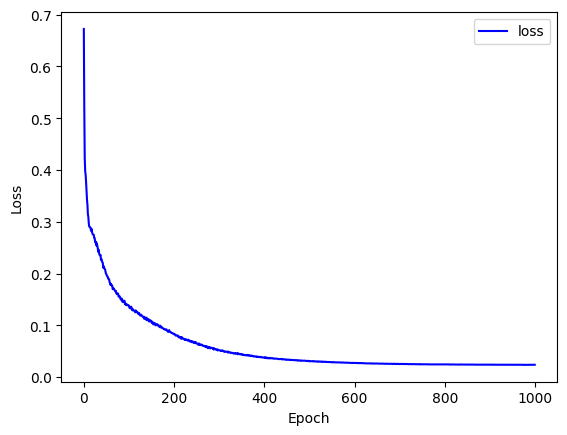

In [30]:
rand_indices = np.random.permutation(range(df.shape[0]))
train_size = math.ceil(len(df)*(1-sample_rate))
df_train = df.iloc[rand_indices[:train_size]]
df_test = df.iloc[rand_indices[train_size:]]

le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
df_train['user_idx'] = le_user.fit_transform(df_train['userId'].values)
df_train['item_idx'] = le_item.fit_transform(df_train['jokeId'].values)
df_train = df_train.sort_values(by=['userId', 'jokeId'], ascending=[True, True])
user_ids = sorted(df_train['userId'].unique())
item_ids = sorted(df_train['jokeId'].unique())
num_user = len(user_ids)
num_item = len(item_ids)

def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + posEmb0.norm().pow(2) + negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss


def data_loader(data, batch_size, n_usr, n_itm):
    # --- 새로운 부분 시작 ---
    # 사용자별로 '좋아요'와 '싫어요' 목록을 미리 만들어 둡니다.
    # 여기서 '좋아요'는 평점이 0 이상, '싫어요'는 0 미만으로 정의합니다.
    user_interactions = data.groupby('user_idx')['item_idx'].apply(list).to_dict()
    user_positive_items = data[data['rating'] >= 0].groupby('user_idx')['item_idx'].apply(list).to_dict()
    user_negative_items = data[data['rating'] < 0].groupby('user_idx')['item_idx'].apply(list).to_dict()
    all_items = set(range(n_itm))
    # --- 새로운 부분 끝 ---
    
    # 학습에 참여할 사용자 샘플링
    users = random.sample(list(user_interactions.keys()), batch_size)
    
    pos_items, neg_items = [], []
    for user in users:
        # 이 사용자에게 '좋아요' 목록이 있는 경우에만 샘플링 진행
        if user not in user_positive_items:
            continue
            
        # 1. 긍정 아이템 샘플링
        pos_item = random.choice(user_positive_items[user])
        pos_items.append(pos_item)

        # 2. 부정 아이템 샘플링
        while True:
            # 50% 확률로 명시적인 '싫어요' 목록에서 샘플링 (Hard Negative)
            if user in user_negative_items and random.random() < 0.5:
                neg_item = random.choice(user_negative_items[user])
            # 나머지 50% 확률로 상호작용하지 않은 아이템 중에서 랜덤 샘플링
            else:
                neg_item = random.choice(list(all_items - set(user_interactions[user])))
            
            # 우연히 긍정 아이템과 같은게 뽑혔으면 다시 뽑기
            if neg_item != pos_item:
                neg_items.append(neg_item)
                break
                
    return users, pos_items, neg_items

# def data_loader(data, batch_size, n_usr, n_itm):
#     interected_items_df = data.groupby('user_idx')['item_idx'].apply(list).reset_index()

#     def sample_neg(x):
#         while True:
#             neg_id = random.randint(0, n_itm - 1)
#             if neg_id not in x:
#                 return neg_id

#     indices = [x for x in range(n_usr)]
#     if n_usr < batch_size:
#         users = [random.choice(indices) for _ in range(batch_size)]
#     else:
#         users = random.sample(indices, batch_size)

#     users.sort()
#     users_df = pd.DataFrame(users, columns = ['users'])
#     interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_idx', right_on = 'users')
#     pos_items = interected_items_df['item_idx'].apply(lambda x : random.choice(x)).values
#     neg_items = interected_items_df['item_idx'].apply(lambda x: sample_neg(x)).values

#     return list(users), list(pos_items), list(neg_items)


class LightGCN(nn.Module):
    def __init__(self, data, n_user, n_item, n_layers, latent_dim=32):
        super(LightGCN, self).__init__()
        print("LightGCN link prediction")
        self.data = data
        self.num_user = n_user
        self.num_item = n_item
        self.num_layer = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.num_user + self.num_item, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.num_user, self.num_item), dtype = np.float32)
        R[self.data['user_idx'], self.data['item_idx']] = 1.0

        adj_mat = sp.dok_matrix((self.num_user + self.num_item, self.num_user + self.num_item), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: self.num_user, self.num_user :] = R
        adj_mat[self.num_user :, : self.num_user] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Below Code is toconvert the dok_matrix to sparse tensor.
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape
        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor


    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.num_layer):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [self.num_user, self.num_item])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [self.num_user, self.num_item])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed


    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0


# train model
model = LightGCN(df_train, num_user, num_item, num_layer, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_list_epoch = []
for epoch in tqdm(range(epochs)):
    n_batch = int(len(df_train)/batch_size)
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    model.train()
    for batch_idx in range(n_batch):
        optimizer.zero_grad()
        users, pos_items, neg_items = data_loader(df_train, batch_size, num_user, num_item)
        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.forward(users, pos_items, neg_items)
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
        reg_loss = decay * reg_loss
        final_loss = mf_loss + reg_loss
        final_loss.backward()
        optimizer.step()
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())

    model.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = model.propagate_through_layers()

    loss_list_epoch.append(round(np.mean(final_loss_list),4))


score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))
df_score = pd.DataFrame(score, index=user_ids, columns = item_ids)
print(df_score)


# loss graph
losses_np = np.array(loss_list_epoch)
epoch_range = np.arange(1,epochs)
plt.plot(losses_np, color='blue', label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
import pandas as pd
import numpy as np
# 'kmeans1d'는 더 이상 필요 없습니다.

# 1. jokeId와 jokeText가 매핑된 데이터를 미리 준비합니다.
try:
    joke_text_df = pd.read_csv('jester_items.csv')
    joke_id_to_text = pd.Series(joke_text_df.jokeText.values, index=joke_text_df.jokeId).to_dict()
except FileNotFoundError:
    print("오류: 'jester_jokes_categorized_v2.csv' 파일을 찾을 수 없습니다.")
    joke_id_to_text = {}

print("\n" + "*"*50)
print("  사용자별 추천 목록 생성 (Top 10)")
print("*"*50)

# 결과를 보고 싶은 특정 사용자 ID 목록
target_user_ids = [9999] 
all_trained_user_ids = df_score.index
users_to_recommend = [u for u in target_user_ids if u in all_trained_user_ids]

for user_id in users_to_recommend:
    print(f"\n----- 🕵️ User ID: {user_id} 님을 위한 새로운 추천 Top 10 -----")

    # 1. 해당 사용자의 전체 예측 점수 가져오기
    user_scores = df_score.loc[user_id]
    
    # 2. 사용자가 이미 평가한 농담 ID 목록 가져오기
    seen_jokes = df_train[df_train['userId'] == user_id]['jokeId'].unique()
    
    # 3. 전체 예측 점수에서 이미 본 농담 점수는 제거하기
    unseen_scores = user_scores.drop(labels=seen_jokes, errors='ignore')
    
    # 4. 아직 보지 않은 농담들을 점수가 높은 순으로 정렬하여 상위 10개 가져오기
    top_10_unseen_jokes = unseen_scores.sort_values(ascending=False).head(10)
    
    # 5. 결과 출력
    if not top_10_unseen_jokes.empty:
        for i, (joke_id, score) in enumerate(top_10_unseen_jokes.items(), 1):
            joke_text = joke_id_to_text.get(joke_id, f"Joke ID {joke_id} 내용 없음")
            print(f"  {i}. [Joke ID: {joke_id}] (예측 점수: {score:.2f})")
            print(f"     {joke_text.strip()}\n")
    else:
        print("  🤔 추천할 새로운 농담을 찾지 못했습니다.")


**************************************************
  사용자별 추천 목록 생성 (Top 10)
**************************************************

----- 🕵️ User ID: 9999 님을 위한 새로운 추천 Top 10 -----
  1. [Joke ID: 80] (예측 점수: 1.46)
     Hillary, Bill Clinton and the Pope are sitting together on an airplane.

Bill says "I could throw one thousand dollar bill out of this plane and
make one person very happy."

Hillary says "I could throw 10 hundred dollar bills out of the plane and
make 10 people very happy."

The Pope chips in and says "I could throw Bill out of the airplane and make the whole 
country happy."

  2. [Joke ID: 37] (예측 점수: 1.38)
     A Jewish young man was seeing a psychiatrist for an eating and
sleeping disorder. 

"I am so obsessed with my mother... As soon as I go to sleep, I start
dreaming, and everyone in my dream turns into my mother. I wake up in
such a state, all I can do is go downstairs and eat a piece of toast."

The psychiatrist replies:

"What, just one piece of toast, for a big 

In [ ]:
import kmeans1d
import numpy as np
import pandas as pd

# 1. jokeId와 jokeText가 매핑된 데이터를 미리 준비합니다.
# 'jester_items.csv' 파일이 필요합니다.
try:
    joke_text_df = pd.read_csv('jester_items.csv')
    # jokeId를 key로, jokeText를 value로 하는 딕셔너리 생성
    joke_id_to_text = pd.Series(joke_text_df.jokeText.values, index=joke_text_df.jokeId).to_dict()
except FileNotFoundError:
    print("오류: 'jester_items.csv' 파일을 찾을 수 없습니다. 농담 내용을 불러오려면 이 파일이 필요합니다.")
    joke_id_to_text = {}


def user_info(user, df_train, df_score, joke_ids):
    """
    특정 사용자에 대해 각 농담별 평점 예측치와 이미 평가했는지 여부를 리스트로 반환합니다.
    """
    list_select = []
    list_score = []
    
    for joke in joke_ids:
        list_score.append(df_score.loc[user][joke])
        if not df_train[(df_train['userId'] == user) & (df_train['jokeId'] == joke)].empty:
            list_select.append(1)
        else:
            list_select.append(0)
            
    return list_select, list_score

# 학습 데이터에 존재하는 모든 joke_id를 가져옵니다.
all_trained_joke_ids = sorted(df_train['jokeId'].unique())
all_trained_user_ids = sorted(df_train['userId'].unique())

# 2. 결과를 보고 싶은 특정 사용자 ID 목록
target_user_ids = [9999]
# target user가 학습 데이터에 존재하는지 확인
users_to_recommend = [u for u in target_user_ids if u in all_trained_user_ids]

for u in users_to_recommend:
    print(f"\n----- 🕵️ User ID: {u} 님을 위한 추천 -----")
    
    list_select, list_score = user_info(u, df_train, df_score, all_trained_joke_ids)
    
    clusters, centroids = kmeans1d.cluster(list_score, 2)
    recommend_cluster_id = np.argmax(centroids)

    recom_new_jokes = []
    
    for i in range(len(clusters)):
        if clusters[i] == recommend_cluster_id:
            joke_id = all_trained_joke_ids[i]
            # 아직 평가하지 않은 농담만 추천 목록에 추가
            if list_select[i] == 0:
                # 3. jokeId를 이용해 실제 jokeText를 찾아 추가합니다.
                joke_text = joke_id_to_text.get(joke_id, f"Joke ID {joke_id}의 내용을 찾을 수 없습니다.")
                recom_new_jokes.append(joke_text)
    
    # 결과 출력
    if recom_new_jokes:
        print(f"  ✅ 새로운 추천 농담 ({len(recom_new_jokes)}개):")
        # 4. 농담 내용을 하나씩 줄바꿈하여 보여줍니다.
        for idx, joke in enumerate(recom_new_jokes, 1):
            print(f"    {idx}. {joke.strip()}")
    else:
        print("  🤔 새로운 추천 농담을 찾지 못했습니다.")


----- 🕵️ User ID: 9999 님을 위한 추천 (진단 모드) -----
  👍 모델이 추천 그룹으로 분류한 '이미 선호하는' 농담 ID: [np.int64(2), np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(11), np.int64(16), np.int64(17), np.int64(19), np.int64(20), np.int64(21), np.int64(23), np.int64(27), np.int64(28), np.int64(29), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(64), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.int64(72), np.int64(74), np.int64(75), np.int64(76), np.int64(78), np.int64(79), np.int64(80), np.int64(82), np.int64(83), np.int64(84), np.int64(85), np.int64(86), np.int64(87), np.int64(88), np.int64(89), np.int64(90

In [21]:
# df_score가 계산된 바로 다음에 이 코드를 추가하세요.

print("\n" + "*"*50)
print("  모델 성능 평가 (Accuracy & Satisfaction)")
print("*"*50)

# --- 1. 정확도 (RMSE) 계산 ---
actual_ratings = []
pred_ratings = []
errors = []

# 평가 데이터셋(df_test)을 한 줄씩 순회
for _, row in df_test.iterrows():
    user_id = row['userId']
    joke_id = row['jokeId']
    actual_rating = row['rating']
    
    # df_score에 해당 user/joke가 모두 존재하는 경우에만 계산 (오류 방지)
    if user_id in df_score.index and joke_id in df_score.columns:
        pred_rating = df_score.loc[user_id, joke_id]
        
        actual_ratings.append(actual_rating)
        pred_ratings.append(pred_rating)
        errors.append((pred_rating - actual_rating)**2)

if errors:
    mse = sum(errors) / len(errors)
    rmse = mse**0.5
    print(f"✅ 예측 정확도 (RMSE): {rmse:.4f}")
    print("   (0에 가까울수록 예측이 정확합니다.)")
else:
    print("⚠️ RMSE를 계산할 수 없습니다. 평가 데이터셋의 사용자가 학습 데이터에 없습니다.")


**************************************************
  모델 성능 평가 (Accuracy & Satisfaction)
**************************************************
✅ 예측 정확도 (RMSE): 4.0169
   (0에 가까울수록 예측이 정확합니다.)


In [22]:
from sklearn.metrics import ndcg_score

# --- 2. 만족도 (NDCG@10) 계산 ---
k = 10
ndcg_scores = []

# 평가 데이터에 있는 사용자들을 대상으로 한 명씩 평가
test_users = df_test['userId'].unique()

for user_id in test_users:
    if user_id not in df_score.index:
        continue

    # 사용자의 모든 예측 점수를 가져와 높은 순으로 정렬
    user_pred_ratings = df_score.loc[user_id].sort_values(ascending=False)
    
    # 사용자가 실제로 평가한 아이템과 평점 (정답셋)
    true_items = df_test[df_test['userId'] == user_id]
    
    # 예측 점수가 높은 상위 k개 아이템 선정
    top_k_items = user_pred_ratings.head(k)
    
    # scikit-learn의 ndcg_score를 사용하기 위해 형식 맞추기
    # true_relevance: 정답 평점 배열
    # pred_scores: 모델의 예측 점수 배열
    true_relevance = np.zeros((1, k))
    pred_scores = np.zeros((1, k))

    for i, (joke_id, pred_score) in enumerate(top_k_items.items()):
        pred_scores[0, i] = pred_score
        # 추천된 아이템이 실제 평가 목록에 있다면, 그 평점을 relevance 점수로 사용
        if joke_id in true_items['jokeId'].values:
            true_relevance[0, i] = true_items[true_items['jokeId'] == joke_id]['rating'].iloc[0]
            
    user_ndcg = ndcg_score(true_relevance, pred_scores, k=k)
    ndcg_scores.append(user_ndcg)

if ndcg_scores:
    avg_ndcg = np.mean(ndcg_scores)
    print(f"✅ 추천 만족도 (NDCG@{k}): {avg_ndcg:.4f}")
    print("   (1에 가까울수록 좋은 아이템을 상위에 추천합니다.)")
else:
    print("⚠️ NDCG를 계산할 수 없습니다.")

✅ 추천 만족도 (NDCG@10): 0.0545
   (1에 가까울수록 좋은 아이템을 상위에 추천합니다.)
